In [1]:
import pandas as pd
import numpy as np

import jointpmf as jp

c:\Users\rquax1\Repositories\jointpmf_package\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Construct a random BN with a randomly generated structure

In [ ]:
bn_rand = jp.BayesianNetwork()

bn_rand.infer_random_bn_on_dag(10)

bn_rand.dependency_graph.edges

OutEdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (1, 5), (1, 6), (2, 7), (5, 8), (7, 9)])

In [3]:
bn_rand = jp.BayesianNetwork()

# NOTE: this can take an increasing amount of time as the network grows, because it is appending
# conditional variables by optimizing for a target MI (which is for each variable given by the
# function `method_cond_pdf`). This is why I set `max_opt_evals` to a low value, because here
# we just want to test if it works in principle. Efficiency is to be studied later.
bn_rand.infer_random_bn_on_dag(5, lambda node: np.random.randint(2, 4), 
                                   method_cond_pdf=lambda k, m: np.random.uniform(0.1, 0.9) * np.log2(k),
                                   verbose=2, max_opt_evals=50)

bn_rand.dependency_graph.edges

debug: 	I popped node=0 and will now add it to the BN, with predecessors [].
debug: 	appended variable 0 (originally node 0) with 3 values, after 0.0 seconds.
debug: 	I popped node=1 and will now add it to the BN, with predecessors [0].
debug: 		Optimization took 1.3183341026306152 seconds. target_mi=0.39395898521566125 (upper bound: 1.584962500721156), actual_mi=0.3929627253461545, state space of conditioned variables: product of [3].
debug: 	appended variable 1 (originally node 1) with 3 values, after 1.3183341026306152 seconds.
debug: 	I popped node=2 and will now add it to the BN, with predecessors [0].
debug: 		Optimization took 0.7985055446624756 seconds. target_mi=0.88492253100229 (upper bound: 1.0), actual_mi=0.8846172128389681, state space of conditioned variables: product of [3].
debug: 	appended variable 2 (originally node 2) with 2 values, after 2.116839647293091 seconds.
debug: 	I popped node=3 and will now add it to the BN, with predecessors [2].
debug: 		Optimization too

OutEdgeView([(0, 1), (0, 2), (2, 3), (3, 4)])

## Test serialization

In [4]:
import networkx as nx

In [5]:
def graph_to_string(G):
    return ';'.join(f"{node}:{','.join(map(str, neighbors))}" for node, neighbors in G.adjacency())

def string_to_graph(s, convert_nodes_to_int=True):
    G = nx.DiGraph()
    for node_data in s.split(';'):
        if ':' in node_data:
            node, neighbors = node_data.split(':')

            if convert_nodes_to_int:
                node = int(node)

            G.add_node(node)
            if neighbors:
                G.add_edges_from((node, int(neighbor) if convert_nodes_to_int else neighbor) for neighbor in neighbors.split(','))
    return G

In [6]:
list(bn_rand.dependency_graph.edges(data=True))

[(0, 1, {}), (0, 2, {}), (2, 3, {}), (3, 4, {})]

In [7]:
graph_to_string(bn_rand.dependency_graph)

'0:1,2;1:;2:3;3:4;4:'

In [8]:
dep_graph_copy = string_to_graph(graph_to_string(bn_rand.dependency_graph))

list(dep_graph_copy.edges(data=True))

[(0, 1, {}), (0, 2, {}), (2, 3, {}), (3, 4, {})]

In [9]:
import dill

In [10]:
serialized_bn = dill.dumps(bn_rand)

serialized_bn

b'\x80\x04\x95\xcd\x0f\x00\x00\x00\x00\x00\x00\x8c\x11jointpmf.jointpmf\x94\x8c\x0fBayesianNetwork\x94\x93\x94)\x81\x94}\x94(\x8c\x04pdfs\x94]\x94(B_\x01\x00\x00\x80\x04\x95T\x01\x00\x00\x00\x00\x00\x00\x8c\x11jointpmf.jointpmf\x94\x8c\x16JointProbabilityMatrix\x94\x93\x94)\x81\x94}\x94(\x8c\x13joint_probabilities\x94C\xcd\x80\x04\x95\xc2\x00\x00\x00\x00\x00\x00\x00\x8c\ndill._dill\x94\x8c\r_create_array\x94\x93\x94(\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94(K\x01K\x03\x85\x94h\x06\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C\x18\xeb6Z\xfb\xd5\xb5\xe5?\x14\xd4L\x16\xe9R\xc1?@PJ\xfc\xbe\xd5\xc7?\x94t\x94Nt\x94R\x94.\x94\x8c\x0cnumvariables\x94K\x01\x8c\tnumvalues\x94K\x03\x8c\x06labels\x94]\x94\x8c\x08variable\x94aub.\x94B\x9b\x03\x00\x00\x80\x04\x95\x90\x03\x00\x00\x00\x00\x00\x00\x8c\x11jointpmf.jointpm

In [11]:
bn_rand2 = dill.loads(serialized_bn)

list(bn_rand2.dependency_graph.edges(data=True))

[(0, 1, {}), (0, 2, {}), (2, 3, {}), (3, 4, {})]

In [12]:
print(bn_rand.joint_probabilities())
print(bn_rand2.joint_probabilities())

{(0, 0, 0, 0, 0): 3.2250072762262623e-09, (0, 0, 0, 0, 1): 5.915250917137996e-07, (0, 0, 0, 0, 2): 2.3737304008594864e-08, (0, 0, 0, 1, 0): 7.335438416817653e-10, (0, 0, 0, 1, 1): 4.198193680395853e-12, (0, 0, 0, 1, 2): 1.9300686522577924e-13, (0, 0, 0, 2, 0): 3.5904107015506254e-12, (0, 0, 0, 2, 1): 8.794347773327123e-13, (0, 0, 0, 2, 2): 1.4566044622017398e-10, (0, 0, 1, 0, 0): 8.19780822049562e-10, (0, 0, 1, 0, 1): 1.5036273856582138e-07, (0, 0, 1, 0, 2): 6.0339047098760765e-09, (0, 0, 1, 1, 0): 0.0003617938403143197, (0, 0, 1, 1, 1): 2.0706064555479727e-06, (0, 0, 1, 1, 2): 9.51936217158741e-08, (0, 0, 1, 2, 0): 1.373000511084731e-05, (0, 0, 1, 2, 1): 3.3630258461017327e-06, (0, 0, 1, 2, 2): 0.0005570166861934665, (0, 1, 0, 0, 0): 1.763559821074663e-06, (0, 1, 0, 0, 1): 0.0003234690019442837, (0, 1, 0, 0, 2): 1.2980484081008766e-05, (0, 1, 0, 1, 0): 4.0113039611509833e-07, (0, 1, 0, 1, 1): 2.295736121407824e-09, (0, 1, 0, 1, 2): 1.0554368519194507e-10, (0, 1, 0, 2, 0): 1.9633766723

# Construct a small BN with known structure using jointpmf

In [4]:
numvalues = 3
max_evals_srv = 100

bn = jp.BayesianNetwork()

# independent variables to start with (root(s) of the DAG)
bn.append_independent_variable('uniform', numvalues)
indep_var1 = redund_var = len(bn) - 1
bn.append_independent_variable('uniform', numvalues)
indep_var2 = len(bn) - 1

# add a variable which depends on ONE variable
bn.append_dependent_variable([0], numvalues, np.log2(numvalues) * 0.5)
depend1_var = len(bn) - 1

# add a variable which depends on TWO variables
bn.append_dependent_variable([0, 1], numvalues, np.log2(numvalues) * 0.5)
depend2_var = len(bn) - 1

In [5]:
# append a synergistic variable
bn.append_synergistic_variable([0, 1], numvalues, max_evals=max_evals_srv)
srv_var = len(bn) - 1

# add a REDUNDANT variable given ONE existing variable
bn.append_dependent_variable([4], numvalues)
redund_var = len(bn) - 1

In [6]:
assert len(bn) == 6

print(f'{bn.mutual_information([srv_var], [indep_var1])=}, target: 0.0')
print(f'{bn.mutual_information([srv_var], [indep_var2])=}, target: 0.0')
print(f'{bn.mutual_information([srv_var], [indep_var1, indep_var2])=}, target: {np.log2(numvalues)}')

print(f'{bn.mutual_information([indep_var1], [depend1_var])=}, target was: {np.log2(numvalues) * 0.5}')
print(f'{bn.mutual_information([indep_var1, indep_var2], [depend2_var])=}, target was: {np.log2(numvalues) * 0.5}')

np.testing.assert_almost_equal(bn.mutual_information([indep_var2], [depend1_var]), 0.0)

bn.mutual_information([srv_var], [indep_var1])=0.008094612779311783, target: 0.0
bn.mutual_information([srv_var], [indep_var2])=0.005027387678858242, target: 0.0
bn.mutual_information([srv_var], [indep_var1, indep_var2])=1.0591780063248482, target: 1.584962500721156
bn.mutual_information([indep_var1], [depend1_var])=0.7911008311101044, target was: 0.792481250360578
bn.mutual_information([indep_var1, indep_var2], [depend2_var])=0.7921240908062033, target was: 0.792481250360578


In [7]:
bn.generate_sample()

[1, 0, 2, 1, 0, 1]

In [8]:
bn.generate_samples(3)

array([[2, 1, 0, 0, 0, 1],
       [2, 0, 0, 2, 2, 0],
       [2, 1, 0, 0, 0, 1]], dtype=int8)

# Infer back a BN from data

In [9]:
num_samples = 2000

raw_data = bn.generate_samples(num_samples)
data = pd.DataFrame(raw_data, columns=[f'v{cix}' for cix in range(len(bn))])

In [10]:
data  # get a flavor of the data

v0  v1  v2  v3  v4  v5
0      0   0   1   1   1   2
1      2   1   1   0   0   1
2      0   2   1   0   0   1
3      2   1   0   0   0   1
4      1   0   2   1   0   1
...   ..  ..  ..  ..  ..  ..
1995   1   0   1   1   0   1
1996   1   1   1   0   1   2
1997   2   1   0   0   0   1
1998   1   1   1   0   1   2
1999   2   2   0   1   1   2

[2000 rows x 6 columns]

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

  0%|          | 6/1000000 [00:00<4:09:16, 66.86it/s]


[('v0', 'v2'), ('v0', 'v3'), ('v1', 'v3'), ('v2', 'v1'), ('v4', 'v5')]


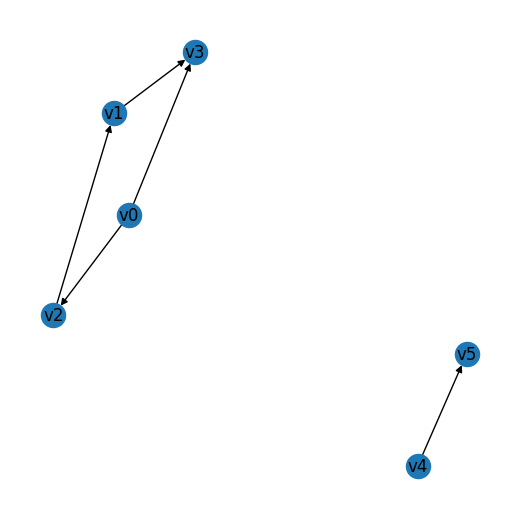

In [12]:
edges = jp.BayesianNetwork.estimate_structure(data)

# these are the edges found by the MMHC estimator:
print(edges)

inferred_digraph = nx.DiGraph(edges)

plt.figure(figsize=(5, 5))
nx.draw(inferred_digraph, with_labels=True)

assert nx.is_directed_acyclic_graph(inferred_digraph), 'structure should be a DAG'

In [13]:
bn2 = jp.BayesianNetwork()

bn2.infer_bn_on_dag(data, edges)

{'v0': 0, 'v4': 1, 'v2': 2, 'v5': 3, 'v1': 4, 'v3': 5}

In [14]:
bn2.draw_graph();  # in the end, this is the inferred BN

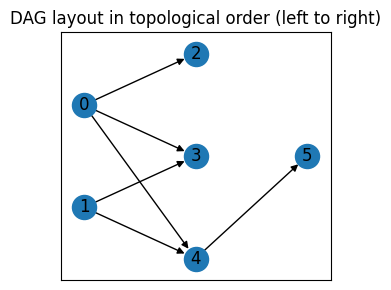

In [15]:
bn.draw_graph();  # compare with the original BN (the one that generated the data)

In [16]:
import itertools
import seaborn as sns

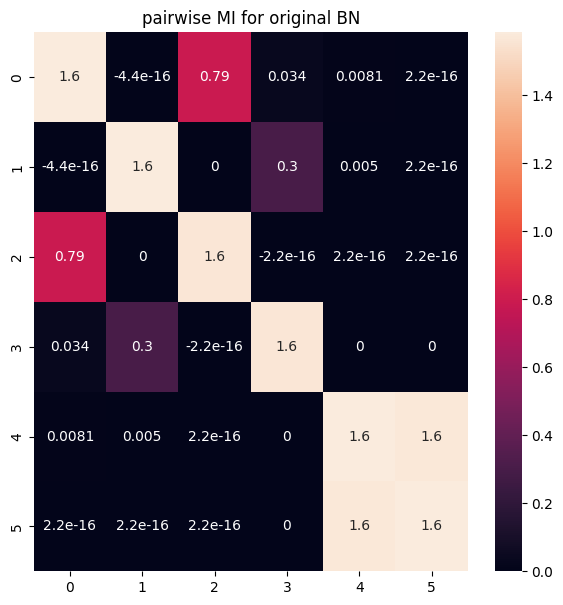

In [17]:
bn.draw_correlation_matrix(title='pairwise MI for original BN');

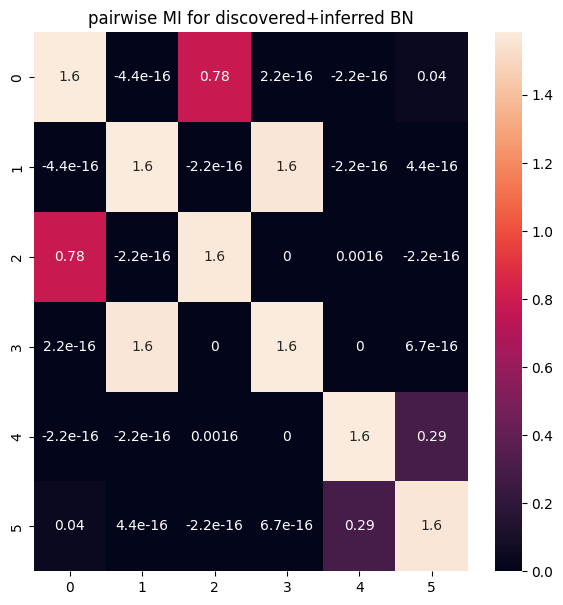

In [18]:
bn2.draw_correlation_matrix(title='pairwise MI for discovered+inferred BN');

# Construct a large BN using a 'catalog' of SRVs

## Doing it once

In [19]:
numvalues = 3
max_evals_srv = 100

bn = jp.BayesianNetwork()

# independent variables to start with (root(s) of the DAG)
bn.append_independent_variable('uniform', numvalues)
indep_var1 = redund_var = len(bn) - 1
bn.append_independent_variable('uniform', numvalues)
indep_var2 = len(bn) - 1

# add a variable which depends on TWO variables
bn.append_synergistic_variable([0, 1], numvalues=numvalues, max_evals=max_evals_srv)

In [20]:
print(f'WMS of SRV: {bn.wms([0, 1], [2])} (maximum possible {np.log2(3.)})')

WMS of SRV: 1.0790541765004154 (maximum possible 1.584962500721156)


In [21]:
cond_pmf_srv = bn.conditional_probabilities([2], [0, 1])

print(type(cond_pmf_srv))
print(type(cond_pmf_srv.cond_pdf[(0, 0)]))

cond_pmf_srv.to_dict()

<class 'jointpmf.jointpmf.ConditionalProbabilityMatrix'>
<class 'jointpmf.jointpmf.BayesianNetwork'>


{(0, 0): [0.00022724310216759577, 0.9918524506447935, 0.007920306253038804],
 (0, 1): [0.9770493194412986, 0.021878120938423798, 0.0010725596202775089],
 (0, 2): [0.04644813081632792, 0.0727029927087629, 0.8808488764749092],
 (1, 0): [0.06690455670027085, 0.1146362033652685, 0.8184592399344607],
 (1, 1): [0.1611317366024534, 0.7659645462438424, 0.07290371715370426],
 (1, 2): [0.8502446257460011, 0.0683456795073025, 0.08140969474669638],
 (2, 0): [0.9648091869789367, 0.002881834661661958, 0.032308978359401344],
 (2, 1): [0.004314735024354394, 0.017570463620469313, 0.9781148013551763],
 (2, 2): [0.051607201146841156, 0.8994268978391338, 0.048965901014025086]}

In [22]:
_precomputed_srvs = []

In [23]:
_precomputed_srvs.append(cond_pmf_srv)

## A loop

In [24]:
numvalues = 3
max_evals_srv = 200

In [25]:
# this is the 'catalog' of all precomputed SRVs. You can similarly make also a catalog of single input variables
_precomputed_srvs = []

In [26]:
for i in range(10):
    bn = jp.BayesianNetwork()

    # NOTE: right now the precomputed SRVs do not come from data but of course they could come from the top O-info triplets identified already earlier, from some dataset (!)

    # independent variables to start with (root(s) of the DAG)
    bn.append_independent_variable('uniform', numvalues)
    indep_var1 = redund_var = len(bn) - 1
    bn.append_independent_variable('uniform', numvalues)
    indep_var2 = len(bn) - 1

    # add a variable which depends on TWO variables
    bn.append_synergistic_variable([0, 1], numvalues=numvalues, max_evals=max_evals_srv)

    print(f'WMS of SRV: {bn.wms([0, 1], [2])} (maximum possible {np.log2(numvalues)})')

    if bn.wms([0, 1], [2]) / np.log2(numvalues) > 0.5:
        cond_pmf_srv = bn.conditional_probabilities([2], [0, 1])

        _precomputed_srvs.append(cond_pmf_srv)
    else:
        print(f'\t(SRV was not good enough so it was not appended)')

WMS of SRV: 1.5210812498159332 (maximum possible 1.584962500721156)
WMS of SRV: 1.3622710645188618 (maximum possible 1.584962500721156)
WMS of SRV: 1.3363542393612438 (maximum possible 1.584962500721156)
WMS of SRV: 1.1130283280110413 (maximum possible 1.584962500721156)
WMS of SRV: 1.5159444560197348 (maximum possible 1.584962500721156)
WMS of SRV: 0.9892903692257338 (maximum possible 1.584962500721156)
WMS of SRV: 1.357184698486923 (maximum possible 1.584962500721156)
WMS of SRV: 1.4393963903432587 (maximum possible 1.584962500721156)
WMS of SRV: 1.3830175737191768 (maximum possible 1.584962500721156)
WMS of SRV: 1.1956326162263082 (maximum possible 1.584962500721156)


In [ ]:
for cond_pmf_srv in _precomputed_srvs:
    print('-----------------------')
    print(cond_pmf_srv.to_dict())

-----------------------
{(0, 0): [0.0008113524145651058, 0.004900069709519924, 0.9942885778759151], (0, 1): [0.01652838744726927, 0.9798655171552054, 0.0036060953975252815], (0, 2): [0.9931029777244312, 0.0006193039025525942, 0.006277718373016171], (1, 0): [0.9985301091296465, 0.0014628298501755824, 7.061020177958356e-06], (1, 1): [0.000833469735237108, 0.0006723770919390991, 0.9984941531728238], (1, 2): [0.0011143833995362071, 0.9949034657960515, 0.00398215080441229], (2, 0): [0.002556399562878679, 0.9887160271375185, 0.008727573299602774], (2, 1): [0.9961337867168606, 0.0014961752213215034, 0.0023700380618179046], (2, 2): [0.0005410523302529257, 0.0088823884962012, 0.9905765591735458]}
-----------------------
{(0, 0): [0.9923109300201635, 0.006123861262876301, 0.0015652087169602373], (0, 1): [0.027185532362626382, 0.00777740660330618, 0.9650370610340675], (0, 2): [0.11096383200233678, 0.8630156943494031, 0.026020473648260187], (1, 0): [0.022976834575480866, 0.9592782581970041, 0.0177

In [28]:
def heuristic_distance_between_srvs(cond_pmf_srv1: jp.ConditionalProbabilityMatrix, cond_pmf_srv2: jp.ConditionalProbabilityMatrix) -> float:
    """Gives some heuristic distance between two SRVs, which can be used to remove very similar SRVs from the 'catalog'.

    Args:
        cond_pmf_srv1 (jp.ConditionalProbabilityMatrix): _description_
        cond_pmf_srv2 (jp.ConditionalProbabilityMatrix): _description_

    Returns:
        float: _description_
    """
    dist = 0.0

    cond_pmf_srv1_dict = cond_pmf_srv1.to_dict()
    cond_pmf_srv2_dict = cond_pmf_srv2.to_dict()

    for states in cond_pmf_srv1_dict.keys():
        probarray1 = np.array(cond_pmf_srv1_dict[states], dtype=float)
        probarray2 = np.array(cond_pmf_srv2_dict[states], dtype=float)

        dist += np.linalg.norm(probarray1 - probarray2)

    return dist

In [29]:
for srv1_ix in range(len(_precomputed_srvs)):
    for srv2_ix in range(srv1_ix + 1, len(_precomputed_srvs)):
        print(f'{srv1_ix=}, {srv2_ix=}: heuristic_distance_between_srvs={heuristic_distance_between_srvs(_precomputed_srvs[srv1_ix], _precomputed_srvs[srv2_ix])}')

srv1_ix=0, srv2_ix=1: heuristic_distance_between_srvs=12.310310282395442
srv1_ix=0, srv2_ix=2: heuristic_distance_between_srvs=8.346031318966462
srv1_ix=0, srv2_ix=3: heuristic_distance_between_srvs=9.11346261471415
srv1_ix=0, srv2_ix=4: heuristic_distance_between_srvs=8.422511742458235
srv1_ix=0, srv2_ix=5: heuristic_distance_between_srvs=9.395081921135278
srv1_ix=0, srv2_ix=6: heuristic_distance_between_srvs=12.327909852515472
srv1_ix=0, srv2_ix=7: heuristic_distance_between_srvs=8.405048539350533
srv1_ix=0, srv2_ix=8: heuristic_distance_between_srvs=8.343261163367767
srv1_ix=0, srv2_ix=9: heuristic_distance_between_srvs=10.944281803247595
srv1_ix=1, srv2_ix=2: heuristic_distance_between_srvs=8.145465399398317
srv1_ix=1, srv2_ix=3: heuristic_distance_between_srvs=7.371585334238865
srv1_ix=1, srv2_ix=4: heuristic_distance_between_srvs=8.270429573170034
srv1_ix=1, srv2_ix=5: heuristic_distance_between_srvs=6.25384500759617
srv1_ix=1, srv2_ix=6: heuristic_distance_between_srvs=12.099161

# Toy model building

In [30]:
# PSEUDOCODE: randomly select an SRV; randomly select the two inputs to this SRV; add it
new_srv_ix = bn.append_conditional_variable(_precomputed_srvs[np.random.randint(len(_precomputed_srvs))],  # this is now specific to 2-input variables but can also be 1-input with some probability
                                            [0, 1], # replace this by randomly selected variables
                                            numvalues=numvalues)
# the return value is the index of the added variable (SRV) in the array of variables in the BN

In [31]:
# optional: you could try to add all SRVs in turn and calculate WMS for each with the inputs; then keep the SRV with the largest WMS